In [9]:
import os
import getpass

from datasets import load_dataset, DatasetDict
from huggingface_hub import login
from transformers import AutoTokenizer
from dotenv import load_dotenv
import matplotlib.pyplot as plt


## Create Chunked Dataset

In [10]:

load_dotenv('.envrc')
if 'HF_TOKEN' in os.environ:
    login(token=os.environ['HF_TOKEN'])
else:
    login(token=getpass.getpass('Huggingface token: '))

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [11]:
# DATASET_REPO = 'roneneldan/TinyStories'
# STORY_KEY = 'text'
DATASET_REPO = 'SimpleStories/SimpleStories'
STORY_KEY = 'story'

CHUNK_LENGTH = 128

TOKENIZER_MODEL = 'SimpleStories/SimpleStories-35M'
TRAIN_SPLIT_PERCENTAGE = 4

In [12]:

dataset = load_dataset(DATASET_REPO, split='train')
print('Total rows:', len(dataset))


Total rows: 2115696


In [13]:
# tokenize the dataset  
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_MODEL)
tokenizer.pad_token = tokenizer.eos_token
def tokenize_function(examples):
    return tokenizer(examples[STORY_KEY], truncation=False, padding='do_not_pad')
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names).select_columns(['input_ids'])

tokenized_dataset

Dataset({
    features: ['input_ids'],
    num_rows: 2115696
})

In [14]:

train_dataset, test_dataset = tokenized_dataset.train_test_split(
    test_size=TRAIN_SPLIT_PERCENTAGE / 100,
    seed=42,
).values()

def chunk_dataset_with_map(dataset, token_column='input_ids', chunk_length=CHUNK_LENGTH):
    """
    Memory-efficient version using dataset.map() and batched processing.
    """
    
    def chunk_batch(batch):
        chunked_batch = {col: [] for col in batch.keys()}
        
        for i in range(len(batch[token_column])):
            tokens = batch[token_column][i]
            token_count = len(tokens)
            num_chunks = token_count // chunk_length
            
            for chunk_idx in range(num_chunks):
                start_idx = chunk_idx * chunk_length
                end_idx = start_idx + chunk_length
                chunk_tokens = tokens[start_idx:end_idx]
                
                # Add chunk to batch
                for col in batch.keys():
                    if col == token_column:
                        chunked_batch[col].append(chunk_tokens)
                    else:
                        chunked_batch[col].append(batch[col][i])
        
        return chunked_batch
    
    # Use map with batched=True for memory efficiency
    chunked_dataset = dataset.map(
        chunk_batch,
        batched=True,
        remove_columns=dataset.column_names,  # Remove original columns
        batch_size=1000,  # Adjust based on your memory constraints
    )
    
    return chunked_dataset
chunked_dataset_train = chunk_dataset_with_map(train_dataset, chunk_length=CHUNK_LENGTH)
chunked_dataset_test = chunk_dataset_with_map(test_dataset, chunk_length=CHUNK_LENGTH)

Map:   0%|          | 0/2031068 [00:00<?, ? examples/s]

Map:   0%|          | 0/84628 [00:00<?, ? examples/s]

In [21]:
print("Train dataset length:", len(chunked_dataset_train))
print("Test dataset length:", len(chunked_dataset_test))
split_dataset = DatasetDict({
    'train': chunked_dataset_train,
    'test': chunked_dataset_test
})
split_dataset.push_to_hub(f"MikiV/{DATASET_REPO.replace('/', '-')}-chunked-{CHUNK_LENGTH}", private=True)


Train dataset length: 3653646
Test dataset length: 152426


Uploading the dataset shards:   0%|          | 0/4 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/MikiV/SimpleStories-SimpleStories-chunked-128/commit/a4ea705e618be492bd78aa1929b2e0bee745586d', commit_message='Upload dataset', commit_description='', oid='a4ea705e618be492bd78aa1929b2e0bee745586d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/MikiV/SimpleStories-SimpleStories-chunked-128', endpoint='https://huggingface.co', repo_type='dataset', repo_id='MikiV/SimpleStories-SimpleStories-chunked-128'), pr_revision=None, pr_num=None)

## Dataset Exploration

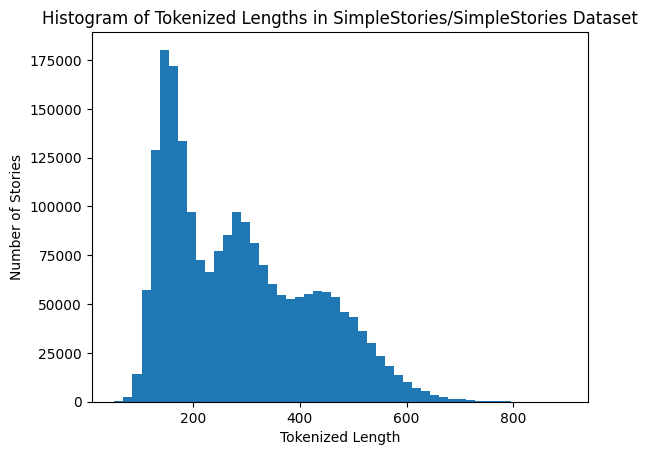

In [16]:
# Historgram of tokenized lengths
lengths = [len(x) for x in tokenized_dataset['input_ids']]
plt.hist(lengths, bins=50)
plt.xlabel('Tokenized Length')
plt.ylabel('Number of Stories')
plt.title(f'Histogram of Tokenized Lengths in {DATASET_REPO} Dataset')
plt.show()

In [17]:
total_tokens_train = len(chunked_dataset_train)*CHUNK_LENGTH/1e6
total_tokens_test = len(chunked_dataset_test)*CHUNK_LENGTH/1e6
total_tokens_original = sum(lengths)/1e6
print(f"Total available tokens = {total_tokens_original}M tokens")
print(f"Total tokens in chunked dataset (train) = {total_tokens_train}M tokens")
print(f"Total tokens in chunked dataset (test) = {total_tokens_test}M tokens")
print(f"We are left with {(total_tokens_train + total_tokens_test)/total_tokens_original * 100}% of the original tokens (train)")

Total available tokens = 608.617592M tokens
Total tokens in chunked dataset (train) = 467.666688M tokens
Total tokens in chunked dataset (test) = 19.510528M tokens
We are left with 80.04652221751752% of the original tokens (train)


In [18]:
for thresh in [64, 128, 256, 512]:
    x = sum(l >= thresh for l in lengths) / len(lengths) * 100
    print(f"{x}% of stories are at least {thresh} tokens")

99.9950370941761% of stories are at least 64 tokens
94.04508020055812% of stories are at least 128 tokens
52.60907049027838% of stories are at least 256 tokens
7.031728565918733% of stories are at least 512 tokens


In [19]:
tokenizer.get_vocab()

{'prom': 733,
 'tricks': 2290,
 'blossomed': 3333,
 '##ried': 566,
 '##iches': 2467,
 'task': 3639,
 'answer': 1883,
 'ring': 2372,
 'closer': 853,
 '##owed': 2269,
 'exp': 498,
 'fill': 292,
 'que': 1764,
 'pretended': 3731,
 'glow': 552,
 'safe': 1376,
 'patience': 3435,
 '##roud': 789,
 'reply': 3762,
 'sk': 342,
 '##vor': 1649,
 'act': 1510,
 'horiz': 2710,
 'shaking': 2332,
 'eat': 2412,
 'trea': 339,
 'greatest': 2037,
 'smart': 2641,
 'choice': 1778,
 'did': 536,
 'painting': 1387,
 'clock': 1620,
 'hot': 2885,
 'flash': 1523,
 'frag': 3474,
 'eff': 3055,
 'connections': 4081,
 'trip': 2994,
 'playful': 2577,
 'warned': 2182,
 'complet': 3421,
 '##ag': 174,
 'm': 44,
 'winding': 3486,
 'someone': 1260,
 'celebration': 2126,
 'pupp': 2221,
 'scent': 2903,
 'fit': 2906,
 'squea': 2998,
 'under': 396,
 'sugg': 1600,
 'could': 219,
 'feast': 2229,
 'transfor': 1645,
 'feelings': 2038,
 'snowballs': 3918,
 'ridd': 2775,
 '##haps': 2542,
 'river': 867,
 'supplies': 3793,
 'pointed': 1

In [20]:
# Ove chunked dataset, find the most common tokens and what percentage of the dataset they cover
from collections import Counter
all_tokens = [token for chunk in chunked_dataset['input_ids'] for token in chunk]
token_counts = Counter(all_tokens)
total_tokens = len(all_tokens)
most_common = token_counts.most_common(20)
for token, count in most_common:
    print(f"Token: {token} ({tokenizer.decode([token])}), Count: {count}, Percentage: {count/total_tokens*100:.2f}%")

NameError: name 'chunked_dataset' is not defined